<a href="https://colab.research.google.com/github/reypapin/Domain-Name-Classification-with-Contextual-Learning/blob/main/ollama_mistral_test_2_prompt_reason.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ollama

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
! sudo apt-get install -y pciutils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pciutils is already the newest version (1:3.7.0-6).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [12]:
! curl https://ollama.ai/install.sh | sh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0>>> Downloading ollama...
100 10091    0 10091    0     0  38233      0 --:--:-- --:--:-- --:--:-- 38368
############################################################################################# 100.0%
>>> Installing ollama to /usr/local/bin...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> NVIDIA GPU installed.
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


In [13]:
import os
import threading
import subprocess
import requests
import json

def ollama():
    os.environ['OLLAMA_HOST'] = '0.0.0.0:11434'
    os.environ['OLLAMA_ORIGINS'] = '*'
    subprocess.Popen(["ollama", "serve"])

In [14]:
ollama_thread = threading.Thread(target=ollama)
ollama_thread.start()

In [7]:
! ollama run mistral

pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠼ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠇ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠙ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠼ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠧ pulling manifest ⠧ pulling manifest ⠏ pulling manifest 
pulling e8a35b5937a5...   0% ▕▏    0 B/4.1 GB                  pulling manifest 
pulling e8a35b5937a5...   0% ▕▏    0 B/4.1 GB                  pulling manifest 
pulling e8a35b5937a5...   0% ▕▏    0 B/4.1 GB                  pulling manifest 
pulling e8a35b5937a5...   0% ▕▏    0 B/4.1 GB                  pulling manifest 
pulling e8a35b5937a5...   0% ▕▏    0 B/4.1 GB                  pulling manifest 
pulling e8a35b5937a5...   0% ▕▏    0 B/4.1 GB                  pulling manifest 
pulling e8a35b5937a5...   0% ▕▏    0 B/4.1 GB                  pulling manifest 
pulling e8a35b5937a5...   0% ▕▏    0 B/4.1 GB         

In [15]:
ollama_thread = threading.Thread(target=ollama)
ollama_thread.start()

In [9]:
import pandas as pd
import requests
import json

# File paths
dga_test_file = "/content/drive/My Drive/df_dga_test.csv"
normal_test_file = "/content/drive/My Drive/df_normal_test.csv"
dga_train_file = "/content/drive/My Drive/df_dga_train.csv"
normal_train_file = "/content/drive/My Drive/df_normal_train.csv"

# Load CSV files into dataframes
df_dga_test = pd.read_csv(dga_test_file)
df_dga_test_limited = df_dga_test.groupby('family').head(10)  # Remember are 54 family

df_normal_test = pd.read_csv(normal_test_file, nrows=500)

df_dga_train = pd.read_csv(dga_train_file)
df_normal_train = pd.read_csv(normal_train_file)

print(len(df_dga_test_limited))
print(len(df_normal_test))

540
500


In [16]:
import requests
import json
import pandas as pd

# Function to create and shuffle datasets
def create_datasets(dga_train_size, normal_train_size):
    dga_train_size = dga_train_size/50
    df_dga_train_limited = df_dga_train.groupby('family').head(dga_train_size)
    df_normal_train_limited = df_normal_train.head(normal_train_size)

    train_df = pd.concat([df_dga_train_limited, df_normal_train_limited])
    train_df['labels'] = train_df['domain'].apply(lambda x: 0 if x in df_normal_train_limited['domain'].values else 1)

    #test_df = df_normal_test
    test_df = pd.concat([df_dga_test_limited, df_normal_test])
    test_df['labels'] = test_df['domain'].apply(lambda x: 0 if x in df_normal_test['domain'].values else 1)

    train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
    test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

    return train_df, test_df



def get_reasoning(df, url='http://localhost:11434/api/chat'):
    # Create the introductory statement
    intro = (
        "You are a domain name classification system. Your task is to classify domain names as either 'dga' (Domain Generation Algorithm) or 'normal'. "
        "DGA domains are automatically generated by malware, while normal domains are not. "
        "I will provide you with labeled training data containing domain names and their classifications. "
        "After the training phase, you will classify some new domains with a brief reasoning and then I will provide the correct labels for those domains. "
        "Finally, you will classify a new domain and respond with either 'dga' or 'normal'. \n\n"
    )

    # Add labeled examples from the DataFrame
    prompt = intro
    remaining_df = df.sample(n=20, random_state=42)
    labeled_df = df.drop(remaining_df.index) # Shuffle the DataFrame to ensure randomness
    for _, row in labeled_df.iterrows():
        label = "dga" if row['labels'] == 1 else "normal"
        prompt += f"{row['domain']}\n{{ 'domain': '{row['domain']}', 'result': '{label}' }}\n\n"

    # Select 10 random domains from the remaining DataFrame for the unlabeled set
    unlabeled_df = remaining_df.sample(10)
    unlabeled_domains = unlabeled_df['domain'].tolist()

    # Add unlabeled examples for the model to classify with reasoning
    prompt += "Now, classify the following domains with a brief reasoning:\n"
    for domain in unlabeled_domains:
        prompt += f"{domain}\n{{ 'domain': '{domain}', 'result': 'classify', 'reasoning': 'Your reasoning here' }}\n\n"

    # Send the first prompt to the model
    payload = {
        "model": "mistral",
        "temperature": 0.6,
        "stream": False,
        "messages": [
            {"role": "system", "content": "You are an AI assistant!"},
            {"role": "user", "content": prompt}
        ]
    }

    response = requests.post(url, json=payload)
    message_str = response.content.decode('utf-8')
    message_dict = json.loads(message_str)
    reasoning_output = message_dict['message']['content']

    # Return the reasoning output and the true labels prompt
    return reasoning_output, unlabeled_df

def classify_domain(domain, df, reasoning_output, unlabeled_df, url='http://localhost:11434/api/chat'):
    # Provide true labels to the model
    true_labels_prompt = "Now, I will provide you with the correct labels for the previously classified domains:\n\n"
    for _, row in unlabeled_df.iterrows():
        true_label = "dga" if row['labels'] == 1 else "normal"
        true_labels_prompt += f"{row['domain']}\n{{ 'domain': '{row['domain']}', 'true_label': '{true_label}' }}\n\n"

    # Include the initial conversation (prompt and responses) in the second prompt
    full_prompt = reasoning_output + "\n\n" + true_labels_prompt
    full_prompt += "Now, please classify the following domain without any reasoning:\n"
    full_prompt += f"{{ 'Now you classify this domain': '{domain}', 'only answer dga or normal, Do not provide any additional information or explanation ': "

    # Send the second prompt to the model
    payload = {
        "model": "mistral",
        "temperature": 0.6,
        "stream": False,
        "messages": [
            {"role": "system", "content": "You are an AI assistant!"},
            {"role": "user", "content": full_prompt + "}}"}
        ]
    }

    response = requests.post(url, json=payload)
    message_str = response.content.decode('utf-8')
    message_dict = json.loads(message_str)
    final_classification = message_dict['message']['content']

    return final_classification

# Test with different sizes of training data
training_sizes = [100, 1000, 1500]



for size in training_sizes:
    dga_train_size = size // 2
    normal_train_size = size // 2
    train_df, test_df = create_datasets(dga_train_size, normal_train_size)

    print(len(test_df))

    # Save train and test datasets for reference
    train_file = f'train_{size}.csv'
    test_file = f'test_{size}.csv'
    train_df.to_csv(train_file, index=False)
    test_df.to_csv(test_file, index=False)

    # Get reasoning output once
    reasoning_output, unlabeled_df = get_reasoning(train_df)

    # Example usage with classification
    print(f"Testing with training size: {size}")
    domains = ["as.com", "youtube.com"]
    for domain in domains:
        print(f"Domain: {domain}, Response: {classify_domain(domain, train_df, reasoning_output, unlabeled_df)}")

    # Apply classify_domain function to each domain in test_df and store the results in a new column
    test_df['classification'] = test_df['domain'].apply(lambda domain: classify_domain(domain, train_df, reasoning_output, unlabeled_df))

    # Save the classification results
    test_results_file = f'test_results_{size}.csv'
    test_df.to_csv(f'/content/drive/My Drive/{test_results_file}', index=False)


    print(f"Test results saved to {test_results_file}")



1040
Testing with training size: 100
Domain: as.com, Response:  The label for the given domain "as.com" is "normal".
Domain: youtube.com, Response:  normal
Test results saved to test_results_100.csv
1040
Testing with training size: 1000
Domain: as.com, Response:  'normal'
Domain: youtube.com, Response:  normal.
Test results saved to test_results_1000.csv
1040
Testing with training size: 1500
Domain: as.com, Response:  The label for the given domain "as.com" is "normal".
Domain: youtube.com, Response:  The domain "youtube.com" is classified as "normal". It is a well-known and widely used video sharing platform, so it is unlikely to be a DGA (Domain Generation Algorithm) domain.
Test results saved to test_results_1500.csv


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Unexpected response format:  the domain "abcdaaaamfcfkfam.co.uk" is likely to be a malicious domain based on its unpronounceable name and the use of the ".co.uk" top-level domain associated with the united kingdom, increasing the risk of it being used for phishing or other fraudulent activities.

reasoning (for completeness): the domain name consists of multiple random letters and numbers, making it difficult to determine its intended purpose without further investigation. the use of a country code top-level domain adds some level of legitimacy, but the unpronounceable name raises suspicions.
Classification Report for Training Size 100:
               precision    recall  f1-score   support

           0       0.93      0.70      0.80       500
           1       0.78      0.95      0.86       539

    accuracy                           0.83      1039
   macr

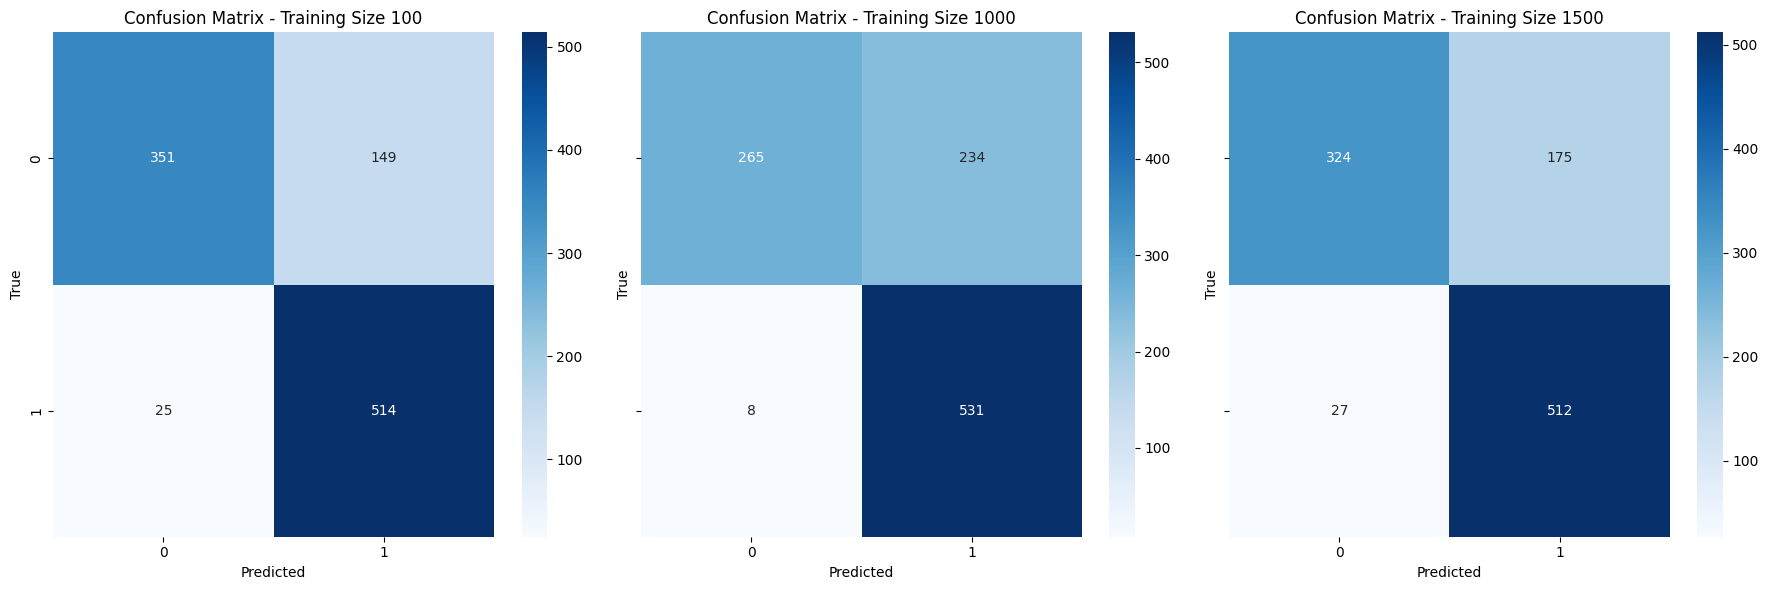

In [18]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import re

# Montar Google Drive
drive.mount('/content/drive')

# Definir los tamaños de las muestras
training_sizes = [100, 1000, 1500]

# Función para convertir las clasificaciones a 1 o 0
def convert_classification(row):
    # Convert the row to lowercase to ensure case-insensitive matching
    row = row.lower()

    # Use regular expressions to find exact matches for 'normal' and 'dga'
    if re.search(r'\bnormal\b', row):
        if re.search(r'\bdga\b', row):
            # Handle cases where both 'normal' and 'dga' appear in the response
            if row.index('normal') < row.index('dga'):
                return 0  # Assume the first occurrence is more likely the intended classification
            else:
                return 1
        return 0
    elif re.search(r'\bdga\b', row):
        return 1
    else:
        # Handle unexpected cases, you might want to log these for further analysis
        print(f"Unexpected response format: {row}")
        return -1  # Or handle in a way appropriate to your use case

# Listas para almacenar los resultados
reports = []
confusion_matrices = []

for size in training_sizes:
    # Cargar los archivos CSV de Google Drive
    test_file = f'test_{size}.csv'
    #test_file = f'/content/drive/My Drive/test_{size}.csv'
    test_results_file = f'/content/drive/My Drive/test_results_{size}.csv'

    test_df = pd.read_csv(test_file)
    test_results_df = pd.read_csv(test_results_file)

    # Convertir la columna de clasificación a 1 o 0
    test_results_df['classification'] = test_results_df['classification'].apply(convert_classification)

    # Calcular las métricas de evaluación
    y_true = test_results_df['labels']
    y_pred = test_results_df['classification']

    # Filtrar cualquier fila con clasificaciones inesperadas (-1)
    valid_indices = y_pred != -1
    y_true = y_true[valid_indices]
    y_pred = y_pred[valid_indices]

    report = classification_report(y_true, y_pred, output_dict=True)
    confusion_matrix_result = confusion_matrix(y_true, y_pred)

    reports.append(report)
    confusion_matrices.append(confusion_matrix_result)

    print(f"Classification Report for Training Size {size}:\n", classification_report(y_true, y_pred))
    print(f"Confusion Matrix for Training Size {size}:\n", confusion_matrix_result)

# Visualizar los resultados
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, size in enumerate(training_sizes):
    sns.heatmap(confusion_matrices[i], annot=True, fmt='d', ax=axes[i], cmap='Blues')
    axes[i].set_title(f'Confusion Matrix - Training Size {size}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')

plt.tight_layout()
plt.show()